# Non-linear optimization

In this third of the session, we are going to discuss how to go about solving non-linear optimization problems of the form:
\begin{align}
\min \ f(x)\\
\text{s.t.} \ g(x)=0,\\
\ \ h(x) \leq 0.
\end{align}
where $f(x)$ is a non-linear function (e.g., linear, quadratic, socp, sdp, exponential), $g(x)$ is an affine function (i.e. linear) and $h(x)$ is a non-linear function. 

For simplicity, we will only consider quadratic and socp non-linear functions today, since they can be solved in Gurobi/CPLEX. However, the ideas we introduce here also translate fairly naturally to more complicated problems.

However, you can also solve problems with more complex non-linear functions than this in JuMP, with Mosek (see https://www.mosek.com/; they have free academic licenses available). Good resources on non-linear optimization are the books by Boyd and Vandenberghe, Bertsekas, and Ben-Tal and Nemirovski.

# SVM's

Our running example for this third of the session will be SVMs, to keep things concrete and illustrate the basic use of JuMP.jl for solving nonlinear optimization problems. We're also going to keep things in 2d, so that we can plot them easily.

Support Vector Machines are a popular model in machine learning for classification. 

Specifically, we are going to build our own custom svm solver, so that we can include constraints which off-the-shelf SVM solvers can't handle. Because we are using JuMP, we should expect that our solver will be slower but more flexible than state-of-the-art SVM solvers such as scikit-learn.

The basic problem is that we are given a set of N points $x_1,x_2,\ldots, x_N \in \mathbb{R}^n$ and labels $y_1, y_2, \ldots, y_n \in \{-1,+1\}$. And we want to find a hyperplane of the form $w^Tx-b = 0$ that separates the two classes, i.e. $w^Tx_i - b \geq 1$ when $y_i = +1$ and $w^Tx_i - b \leq -1$ when $y_i = -1$. This condition can be written as $y_i(w^Tx_i - b) \geq 1, \forall\, i$.

Such a hyperplane will not exist in general if the data overlap, so instead we'll just try to minimize violations of the constraint $y_i(w^Tx_i - b) \geq 1, \forall\, i$ by adding a penalty when it is violated. The optimization problem can be stated as $$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2
$$ Note that we penalize the norm of $w$ in order to guarantee a unique solution.

Now, let's write our own SVM solver!

In [7]:
#Pkg.add("PyPlot", "Distributions", "LinearAlgebra", "PyPlot")
using Gurobi #, Pick your favourite solver here e.g. CPLEX/Gurobi/Mosek. Note that you need to install these solvers to use them
using Distributions
using PyPlot
using LinearAlgebra
using JuMP
using Mosek

In [8]:
# Function to generate some random test data
function gen_data(N)
    # for +1 data, symmetric multivariate normal with center at (1,2)
    pos = rand(MvNormal([1.0,2.0],1.0),N)
    # for -1 data, symmetric multivariate normal with center at (-1,1)
    neg = rand(MvNormal([-1.0,1.0],1.0),N)
    x = [pos neg]
    y = [fill(+1,N);fill(-1,N)]
    return x,y
end

gen_data (generic function with 1 method)

Let's see what the data look like.

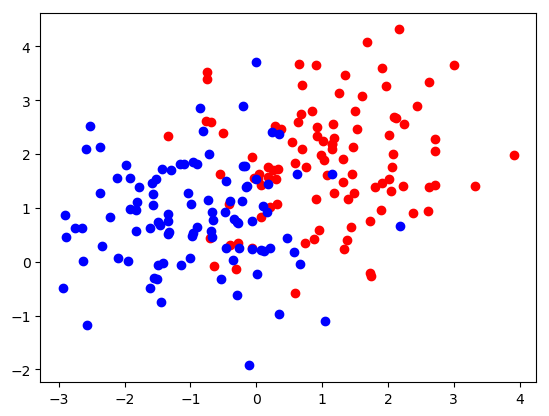

In [9]:
x,y = gen_data(100)
plot(x[1,1:100], x[2,1:100], "ro", x[1,101:200], x[2,101:200], "bo");

Now we translate the optimization problem into JuMP form.

**Exercise: fill in the blanks to write the SVM solver.**

In [10]:
using JuMP
const γ = 0.005
function svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)

    #########################################################
    @constraint(svmModel,z.>=ones(N)-y.*(x'*w-b))
    @objective(svmModel, Min, γ*w'*w+sum(z))
    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

svm (generic function with 1 method)

In [11]:
N = 500
x,y = gen_data(N)

w,b = svm(x,y)

Academic license - for non-commercial use only
Optimize a model with 1000 rows, 1003 columns and 4000 nonzeros
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-03, 5e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-02, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1000 rows, 1003 columns, 4000 nonzeros
Presolved model has 2 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 3
 AA' NZ     : 3.000e+03
 Factor NZ  : 4.006e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.601e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.19594999e+07 -5.92022570e-11  0.00e+00 8.70e-06  1.01e+06     0s
   1   2.11829417e+07 -6.29751544e+02  0.00e+00 2.82e+01  3.90e+04     0s
   2   1.42099640e+07 -2.01575534e+05 

([1.30401, 0.708702], 1.1105114249037673)

And the solution?

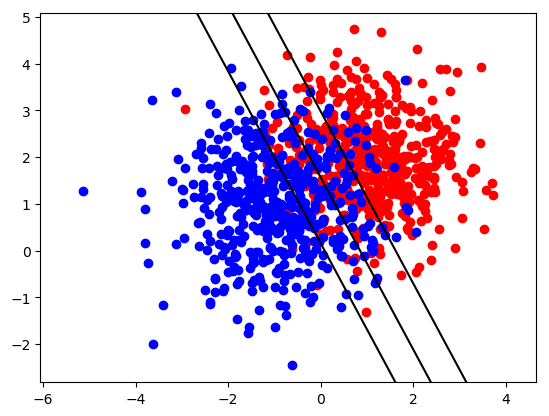

In [12]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b-w[1]*xmin)/w[2]
y2 = (1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b-w[1]*xmin)/w[2]
y2 = (-1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b-w[1]*xmin)/w[2]
y2 = (b-w[1]*xmax)/w[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

# Exercise: The standard support vector classifier

A variant on the support vector classification problem is the *standard* support vector classification problem, which can be stated as follows:
$$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2,
$$
subject to the same constraints as our previous problem (i.e., $l_2$ rather than $l_2^2$ regularization). 

We will not discuss the mathematics of this problem; if you are interested, see section $8.6$ of Boyd+Vandenberghe. 

Exercise: fill in the blanks in the below function, to write a standard support vector machine solver.

Hint: if we have a vector $x$, we can model norm(x) with an auxillary variable $t$ and the constraint:

@constraint(svmModel, soc, norm(w[i] for i=1:n)<=t)

(The "soc" indicates that we are using a second order cone constraint).

In [13]:
using JuMP
const γ = 0.005
function svm2(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)
    @variable(svmModel, t>=0)
    @constraint(svmModel, soc, norm(w[i] for i=1:n)<=t)

    #########################################################
    @constraint(svmModel,z.>=ones(N)-y.*(x'*w-b))
    @objective(svmModel, Min, γ*t+sum(z))
    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

svm2 (generic function with 1 method)

In [14]:
w2,b2 = svm2(x,y)

Academic license - for non-commercial use only
Optimize a model with 1003 rows, 1007 columns and 4006 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [3e-03, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-03, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 1002 rows, 1006 columns, 4004 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 3
 AA' NZ     : 3.003e+03
 Factor NZ  : 4.013e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.604e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.14695128e+03  4.99882384e+02  3.25e-19 5.05e+02  1.98e+00     0s
   1   8.13049247e+02  4.07567353e+02  4.27e-07 3.14e+02  5.91e-01     0s
  

([1.30401, 0.708702], 1.110511945795325)

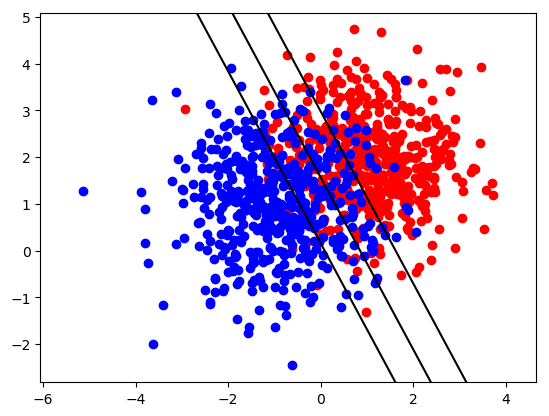

In [15]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b2-w2[1]*xmin)/w2[2]
y2 = (1+b2-w2[1]*xmax)/w2[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b2-w2[1]*xmin)/w2[2]
y2 = (-1+b2-w2[1]*xmax)/w2[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b2-w2[1]*xmin)/w2[2]
y2 = (b2-w2[1]*xmax)/w2[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

# Discussion

What's the difference between the support vector machine solution and the standard support vector machine solution?

When will this difference be substantial?

# Exercise: Sparse support vector machines

A popular way of getting more interpretable/more robust support vector machines is to introduce an $l_0$ norm penalty term into the objective function, and instead solve the following problem (subject to the same constraints as previously):
$$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2+\lambda ||w||_0,$$
which can be modelled via a big-M approach as the following problem:
$$
\min_{w,b, z} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2+\lambda \sum{i=1}^N z_i, \\ \text{s.t.} \ -M z_i \leq w_i \leq M z_i, \forall i.$$

(More efficient approaches than big-M approaches exist, but we will not consider these here.)

Because this problem is NP-hard to solve, people commonly replace the $l_0$ norm term with an $l_1$ term, and instead solve the following problem:
$$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2+\lambda ||w||_1.$$

Exercise: fill in the blanks below to define $l_0$ and $l_1$ norm support vector machine solvers, and compare their performance, in terms of both interpretability and run time.

# $l_1$ norm case

In [30]:
using JuMP
const γ = 0.005
const λ = 200.0
function l1_svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)
    @variable(svmModel, abs_w[1:n])

    #########################################################
    @constraint(svmModel, abs_w.>=w)
    @constraint(svmModel, abs_w.>=-w)
    @constraint(svmModel,z.>=ones(N)-y.*(x'*w-b))
    @objective(svmModel, Min, γ*w'*w+sum(z)+λ*sum(abs_w))
    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

l1_svm (generic function with 1 method)

In [35]:
w3,b3 = l1_svm(x,y)

Academic license - for non-commercial use only
Optimize a model with 1004 rows, 1005 columns and 4008 nonzeros
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-03, 5e+00]
  Objective range  [1e+00, 2e+02]
  QObjective range [1e-02, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolved: 1002 rows, 1005 columns, 4004 nonzeros
Presolved model has 2 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 3
 AA' NZ     : 3.002e+03
 Factor NZ  : 4.010e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.602e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.83594999e+07 -5.92021978e-11  0.00e+00 1.60e+03  1.01e+06     0s
   1   2.17357429e+07 -2.36482038e+02  0.00e+00 2.89e+01  2.84e+04     0s


([0.7506, 0.163161], 0.23420151636701989)

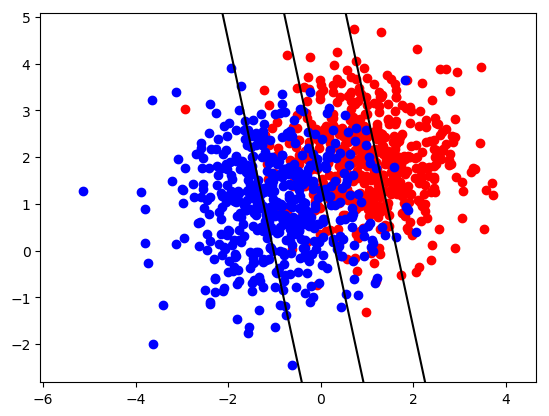

In [36]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b3-w3[1]*xmin)/w3[2]
y2 = (1+b3-w3[1]*xmax)/w3[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b3-w3[1]*xmin)/w3[2]
y2 = (-1+b3-w3[1]*xmax)/w3[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b3-w3[1]*xmin)/w3[2]
y2 = (b3-w3[1]*xmax)/w3[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

# $l_0$ norm case

In [43]:
using JuMP
const γ = 0.005
const λ2 = 100.0
const M = 1000.0 #can get better constants than this.
function l0_svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)
    @variable(svmModel, s[1:n], Bin)

    #########################################################
    @constraint(svmModel, M*s.>=w)
    @constraint(svmModel, M*s.>=-w)
    @constraint(svmModel,z.>=ones(N)-y.*(x'*w-b))
    @objective(svmModel, Min, γ*w'*w+sum(z)+λ2*sum(s))
    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

l0_svm (generic function with 1 method)

In [44]:
w4,b4 = l0_svm(x,y)

Academic license - for non-commercial use only
Optimize a model with 1004 rows, 1005 columns and 4008 nonzeros
Model has 2 quadratic objective terms
Variable types: 1003 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e+00, 1e+02]
  QObjective range [1e-02, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.000000e+12
Presolve time: 0.00s
Presolved: 1004 rows, 1005 columns, 4008 nonzeros
Presolved model has 2 quadratic objective terms
Variable types: 1003 continuous, 2 integer (2 binary)

Root relaxation: objective 3.232108e+02, 1447 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  323.21082    0    2 2.0000e+12  323.21082   100%     -    0s
H    0     0                     523.0095455  323.21082  38.2%     -    0s
     0 

([1.35196, 0.0], 0.06482100070868024)

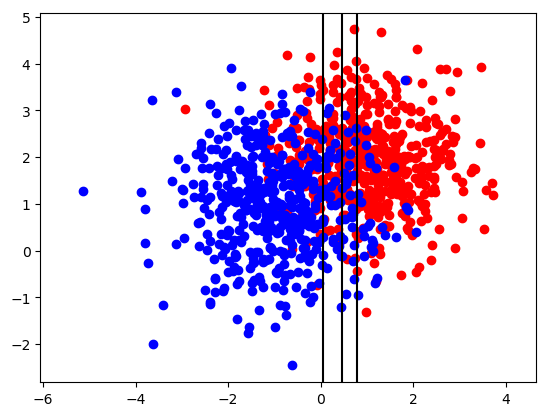

In [56]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b4-w4[1]*xmin)/(w4[2]+1e-8)
y2 = (1+b4-w4[1]*xmax)/(w4[2]+1e-8)
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b4-w4[1]*xmin)/(w4[2]+1e-8)
y2 = (-1+b4-w3[1]*xmax)/(w4[2]+1e-8)
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b4-w4[1]*xmin)/(w4[2]+1e-8)
y2 = (b4-w4[1]*xmax)/(w4[2]+1e-8)
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

Comments:

* As we expect, the $l_0$ approach gives a more interpretable classification, while the $l_1$ approach is faster.
* If we were to increase the dimensionality of the problem from 2d, the $l_0$ approach would work brilliantly until some threshold between $n=100$ and $n=200$, and beyond this threshold it would struggle to even find feasible solutions (we can get around this with stronger big-M free formulations).
* We should not have any issues solving the $l_1$ formulation, provided we can fit the problem in memory.

# Credit

Some of this material is adapted from the 2016 version of this course, written by Yeesian Ng and Miles Lubin. 